In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
from dotenv import load_dotenv
import os

load_dotenv()

os.environ['KAGGLE_USERNAME'] = "trungvit"
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

mri_dataset_path = kagglehub.dataset_download('trungvit/mini-brain3D-dataset') + "/not_skull_stripped"
mri_label_path = kagglehub.dataset_download('trungvit/mri-label') + "/label.csv"

print('Data source import complete.')


Data source import complete.


In [3]:
mri_dataset_path

'/root/.cache/kagglehub/datasets/trungvit/mini-brain3D-dataset/versions/1/not_skull_stripped'

# Building Datasets

In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import io
from PIL import Image
import os

In [5]:
class MRIDataset(Dataset) :

    def __init__(self, root_dir: str, label_path: str, transform = None, label_df: pd.DataFrame = None ):
        self.root_dir = Path(root_dir)
        self.transform = transform
        if label_df is None:
          self.labels_df = pd.read_csv(label_path)
        else :
          self.labels_df = label_df

        self.labels_df['subject_id'] = self.labels_df['subject_id'].astype(str)


        all_nii_files = list(self.root_dir.rglob("*.nii"))
        self.file_paths = [fp for fp in all_nii_files if fp.is_file()]

        valid_subjects = set(self.labels_df['subject_id'].values)
        original_count = len(self.file_paths)

        self.file_paths = [fp for fp in self.file_paths if any(vs in str(fp) for vs in valid_subjects)]
        self.file_paths.sort()



    def __len__(self):
        return len(self.file_paths)

    # chuyen doi ve 3 goc do
    def preprocessing_datapoint(self, img_data):

        mid_x = img_data.shape[0] // 2
        mid_y = img_data.shape[1] // 2
        mid_z = img_data.shape[2] // 2

        axial_slice = img_data[:, :, mid_z]
        coronal_slice = img_data[:, mid_y, :]
        sagittal_slice = img_data[mid_x, :, :]


        combined_data = np.stack([axial_slice, coronal_slice, sagittal_slice], axis=0)
        combined_data = torch.from_numpy(combined_data).float()

        if self.transform : combined_data = self.transform(combined_data)

        return combined_data




    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        file_path_str = str(img_path)

        subject_id = None
        valid_subjects_set = set(self.labels_df['subject_id'].values)


        for sid in valid_subjects_set:
            if sid in file_path_str:
                subject_id = sid
                break

        if subject_id is None:
            raise ValueError(f"Không tìm thấy subject_id cho file: {img_path}")

        metadata = self.labels_df.loc[self.labels_df['subject_id'] == subject_id].iloc[0].to_dict()

        img_data = nib.load(img_path).get_fdata()

        img_data = torch.from_numpy(img_data).float()

        label = 0
        if metadata['subject_sex'] == 'm' : label = 1

        return self.preprocessing_datapoint(img_data),  label



In [6]:
dataset = MRIDataset(mri_dataset_path, mri_label_path)

In [7]:
dataset[0]

(tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[  0.0000,   0.000

In [8]:
len(dataset)

63

In [9]:
def visualize_sample(dataset, idx):
    mri_data, label = dataset[idx]
    title = f"Label: {label}\n"
    plt.close('all')
    fig = plt.figure(figsize = (18, 6))

    if isinstance(mri_data, torch.Tensor):
        data = mri_data.squeeze().numpy()
    else:
        data = mri_data


    ax1 = fig.add_subplot(1, 3, 1)
    plt.imshow(data[0, :, :].T, cmap='gray', origin='lower')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(data[1, :, :].T, cmap='gray', origin='lower')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(data[2, :, :].T, cmap='gray', origin='lower')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

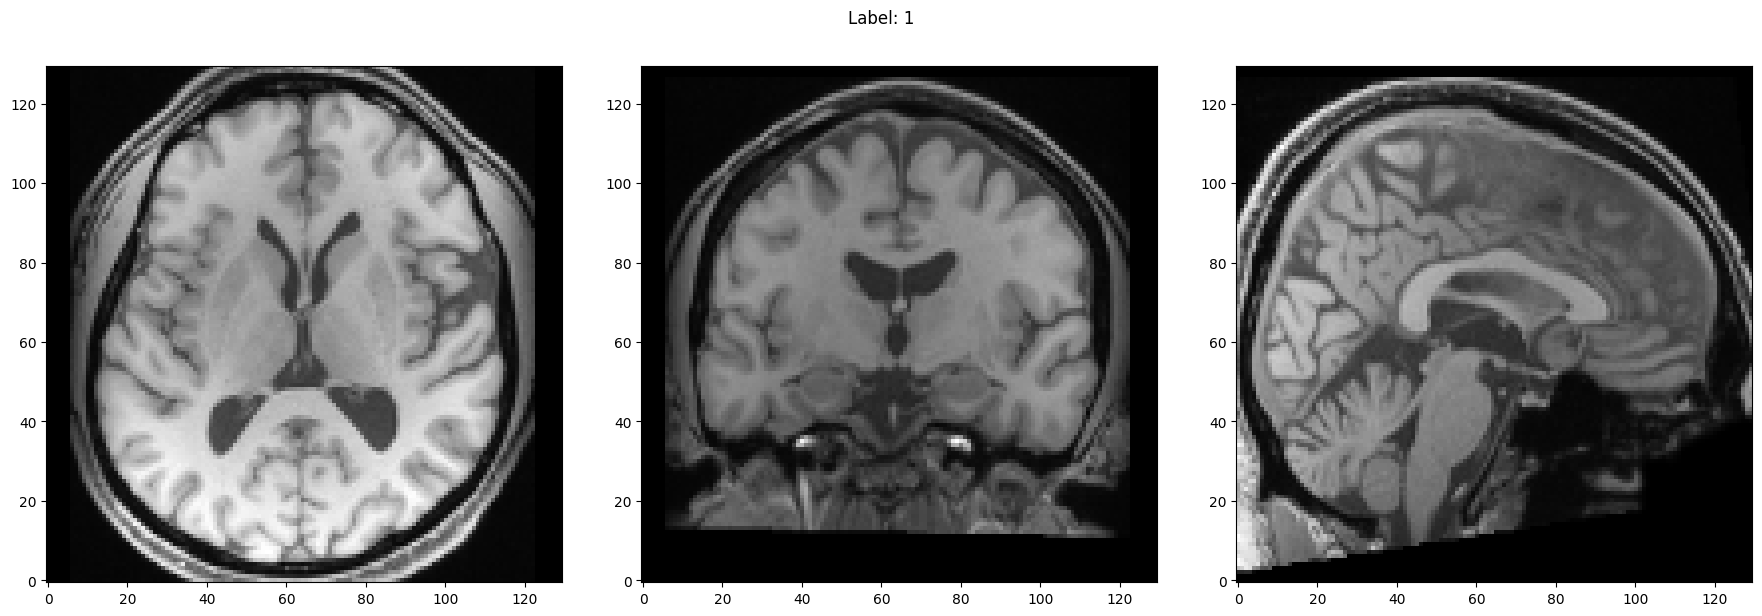

In [10]:
visualize_sample(dataset, 0)

# Define Model

In [11]:
import torch.nn as nn

class BrainMRINet(nn.Module):
    def __init__(self, num_classes=2):
        super(BrainMRINet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )



    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [12]:
def train(model, dataloader, optimizer, criterion, epochs, device):
    """Train the model for given number of epochs."""
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        print(f"Epoch {epoch + 1}/{epochs}")
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total

        print(f"Train - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return avg_loss, accuracy


def test(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # For classification
            loss = criterion(outputs, labels)

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    print(f"Test - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [13]:
from torch.utils.data import random_split

# test training model
def train_model(dataset, model, epochs=10, batch_size=32, learning_rate=0.001):

    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    train(model, train_loader, optimizer, criterion, epochs, device)

    test(model, val_loader, criterion, device)
    test(model, test_loader, criterion, device)

    return model


In [14]:
!pip install -q torchsummary

In [15]:
from torchsummary import summary
summary(BrainMRINet(), (3, 130, 130))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 130, 130]             448
       BatchNorm2d-2         [-1, 16, 130, 130]              32
              ReLU-3         [-1, 16, 130, 130]               0
         MaxPool2d-4           [-1, 16, 65, 65]               0
            Conv2d-5           [-1, 32, 65, 65]           4,640
       BatchNorm2d-6           [-1, 32, 65, 65]              64
              ReLU-7           [-1, 32, 65, 65]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
          Flatten-13                [-1, 16384]               0
           Linear-14                  [

# Running full simulation




In [16]:
!pip install -q flwr[simulation] flwr-datasets[vision]
!pip install cryptography==41.0.7

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.2 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.2 which is incompatible.
  Using cached cryptography-41.0.7-cp37-abi3-manylinux_2_28_x86_64.whl.metadata (5.2 kB)
Using cached cryptography-41.0.7-cp37-abi3-manylinux_2_28_x86_64.whl (4.4 MB)
  Attempting uninstall: cryptography
    Found existing installation: cryptography 44.0.2
    Uninstalling cryptography-44.0.2:
      Successfully uninstalled cryptography-44.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flwr 1.18.0 requires cryptography<45.0.0,>=44.0.1, but you have cryptography 41.0.7 which is incom

In [17]:
import flwr as fl
import torch
from collections import OrderedDict
from flwr.client import NumPyClient, ClientApp


class FlowerClient(NumPyClient):
    def __init__(self, model, train_dataloader, val_dataloader, optimizer, criterion, epochs,  device):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.device = device
        self.criterion = criterion
        self.epochs = epochs

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        if not parameters:
            return

        state_dict = OrderedDict()
        params_dict = zip(self.model.state_dict().keys(), parameters)

        for k, v in params_dict:
            if v.ndim == 0:
                # Handle scalar parameters
                state_dict[k] = torch.tensor(v)
            else:
                # Handle normal tensors
                state_dict[k] = torch.tensor(v)

        # Only load if we have parameters
        if state_dict:
            self.model.load_state_dict(state_dict, strict=False)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train_loss, train_acc = train(self.model, self.train_dataloader, self.optimizer, self.criterion, self.epochs, self.device)
        return self.get_parameters(config={}), len(self.train_dataloader.dataset), {"loss": train_loss, "accuracy": train_acc}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc = test(self.model, self.val_dataloader, self.criterion, self.device)
        return loss, len(self.val_dataloader.dataset), {"accuracy": acc,  "loss": loss}


In [18]:
from torch.utils.data import random_split


def create_client_data(dataset, num_client = 3,  val_ratio = 0.2):

    client_datasets = []
    sample_per_client = len(dataset) // num_client


    for i in range(num_client):
        start_idx = i * sample_per_client
        end_idx = (i + 1) * sample_per_client if i < num_client - 1 else len(dataset)
        indecies = list(range(start_idx, end_idx))

        client_dataset = torch.utils.data.Subset(dataset, indecies)

        train_size = (1 - val_ratio) * len(indecies)
        val_size = val_ratio * len(indecies)

        train_dataset, val_dataset = random_split(client_dataset, [1 - val_ratio, val_ratio])

        client_datasets.append((train_dataset, val_dataset))
    return client_datasets


In [19]:
# init dataset
ROOT_PATH = mri_dataset_path
LABEL_PATH = mri_label_path
NUM_CLIENTS = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 5

full_dataset = MRIDataset(root_dir=ROOT_PATH, label_path=LABEL_PATH)
client_datasets = create_client_data(full_dataset, NUM_CLIENTS)

In [20]:
from flwr.common import Metrics, Context
import torch.optim as optim

def flower_client(context: Context):

    client_id = context.node_config['partition-id']
    train_dataset, val_dataset = client_datasets[client_id]

    train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 2)
    val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 2)

    model = BrainMRINet(num_classes = 2)
    model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.CrossEntropyLoss()
    return FlowerClient(model, train_dataloader, val_dataloader, optimizer, criterion, EPOCHS, DEVICE).to_client()

In [21]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents

def server_func(context: Context):

    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=3,
    )

    config = ServerConfig(num_rounds = 5)
    return ServerAppComponents(strategy=strategy, config=config)

In [22]:
# from flwr.simulation import run_simulation

# client_app = ClientApp(client_fn = flower_client)
# server_app = ServerApp(server_fn = server_func)
# backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
# run_simulation(
#     client_app = client_app,
#     server_app = server_app,
#     num_supernodes=NUM_CLIENTS,
#     backend_config = backend_config
# )

# Chia dữ liệu

In [23]:
import pandas as pd

data_labels = pd.read_csv(mri_label_path)
data_labels.head()


,Unnamed: 0,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech


In [24]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10275 entries, 0 to 10274
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    10275 non-null  int64  
 1   subject_age   10275 non-null  float64
 2   subject_dx    10209 non-null  object 
 3   subject_sex   10275 non-null  object 
 4   subject_id    10275 non-null  object 
 5   dataset_name  10275 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 481.8+ KB


In [25]:
data_labels.drop('Unnamed: 0', axis=1, inplace=True)

In [26]:
def labels_filtering(root_path, df):

  subject_list = []
  for root, dirs, files in os.walk(root_path):
    for dir_name in dirs:
      if dir_name.startswith("sub-BrainAge"):
          subject_list.append(dir_name)


  return df[df['subject_id'].isin(subject_list)]


filtered_label = labels_filtering(mri_dataset_path, data_labels)
filtered_label.head()


,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech


In [27]:
def prepare_data(data: pd.DataFrame):
  df = data.copy()
  required_cols = ['subject_age', 'subject_sex']

  df['age_group'] = pd.qcut(df['subject_age'], q = min(5, len(df)), labels = False)
  stratify_cols = ['age_group', 'subject_sex']

  df['key'] = df.apply(lambda row : f"{row['age_group']}_{row['subject_sex']}", axis = 1)
  return df


prepare_df = prepare_data(filtered_label)
prepare_df.head()



,subject_age,subject_dx,subject_sex,subject_id,dataset_name,age_group,key
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech,4,4_m
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech,2,2_m
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech,4,4_m
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech,1,1_m
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech,4,4_f


In [28]:
def sampling_data(data, size, random_state ):

  samples = data.groupby('key', group_keys = False)


  samples = samples.apply(lambda x: x.sample(
      n = min(int(size / len(data['key'].unique())), len(x)),
      replace = len(x) < int(size / len(data['key'].unique())),
      random_state =  random_state
  ))


  if len(samples) < size:
    additional_samples = data.drop(samples.index).sample(
        n = min(size - len(samples), len(data) - len(samples)),
        replace = True,
        random_state = random_state
    )

    samples = pd.concat([samples, additional_samples])
  return samples


In [29]:
# phan chia du lieu

def distributed_data_to_clients(data: pd.DataFrame, num_clients: int, overlap_ratio: float):

  df = prepare_data(data)

  n_samples = len(df)
  samples_per_client = int(n_samples / (num_clients * (1 - overlap_ratio) + overlap_ratio))

  client_datasets = []
  selected_samples = {}

  # Tạo các client datasets với sự phân bố cân bằng
  for client_idx in range(num_clients):

      if client_idx == 0:
          client_data = df.sample(n=samples_per_client, random_state=42+client_idx)
      else:
          # overlap size
          overlap_size = int(samples_per_client * overlap_ratio)
          non_overlap_size = samples_per_client - overlap_size

          # building overlap
          all_previous_samples = pd.DataFrame()
          for prev_client_idx in range(client_idx):
              all_previous_samples = pd.concat([all_previous_samples, selected_samples[prev_client_idx]])

          # sampling
          if len(all_previous_samples) > 0:
              overlap_samples = sampling_data(all_previous_samples, overlap_size, client_idx * 100 + 42)
          else:
              overlap_samples = pd.DataFrame(columns=df.columns)

          # Lấy mẫu mới (không overlap)
          remaining_indices = df.index.difference(all_previous_samples.index)
          if len(remaining_indices) > 0:
              remaining_df = df.loc[remaining_indices]
              non_overlap_samples = sampling_data(remaining_df, non_overlap_size, client_idx * 100 + 42)
          else:

              non_overlap_samples = df.sample(n=non_overlap_size, replace=True, random_state=42+client_idx*300)


          client_data = pd.concat([overlap_samples, non_overlap_samples])


      selected_samples[client_idx] = client_data
      client_datasets.append(client_data.drop(['age_group', 'key'], axis=1))

  return client_datasets


In [30]:
client_datasets =  distributed_data_to_clients(prepare_df, 3, overlap_ratio=0.6)

<ipython-input-28-c589b012ea1d>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = samples.apply(lambda x: x.sample(
<ipython-input-28-c589b012ea1d>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = samples.apply(lambda x: x.sample(
<ipython-input-28-c589b012ea1d>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future ver

In [31]:
client_datasets[0]

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
61,40.0,control,m,sub-BrainAge000063,ABIDE/CMU_b
57,27.0,pathology,m,sub-BrainAge000059,ABIDE/CMU_b
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
43,27.0,control,m,sub-BrainAge000045,ABIDE/CMU_a
5,37.7,pathology,m,sub-BrainAge000005,ABIDE/Caltech
36,33.0,pathology,m,sub-BrainAge000038,ABIDE/CMU_a
16,21.2,pathology,m,sub-BrainAge000017,ABIDE/Caltech
12,20.1,pathology,m,sub-BrainAge000012,ABIDE/Caltech
25,21.1,control,f,sub-BrainAge000026,ABIDE/Caltech
60,20.0,control,f,sub-BrainAge000062,ABIDE/CMU_b


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import List

def visualize_data_distribution(client_datasets: List[pd.DataFrame], figsize=(15, 15)):

    num_clients = len(client_datasets)
    fig, axes = plt.subplots(2,  1, figsize=figsize)

    # 1. age distribution
    ax_age = axes[0]
    for i, client_df in enumerate(client_datasets):
        sns.kdeplot(
            client_df['subject_age'],
            ax=ax_age,
            label=f'Client {i}',
            fill=True,
            alpha=0.3
        )

    all_data = pd.concat(client_datasets).drop_duplicates()
    sns.kdeplot(
        all_data['subject_age'],
        ax=ax_age,
        label='Tất cả dữ liệu',
        color='black',
        linestyle='--'
    )

    ax_age.set_title('Phân bố tuổi giữa các client', fontsize=14)
    ax_age.set_xlabel('Tuổi', fontsize=12)
    ax_age.set_ylabel('Mật độ', fontsize=12)
    ax_age.legend()

    textbox = ""
    for i, client_df in enumerate(client_datasets):
        textbox += f"Client {i}: Trung bình = {client_df['subject_age'].mean():.2f}, "
        textbox += f"Min = {client_df['subject_age'].min():.2f}, "
        textbox += f"Max = {client_df['subject_age'].max():.2f}, "
        textbox += f"Độ lệch chuẩn = {client_df['subject_age'].std():.2f}\n"

    ax_age.text(
        0.05, -0.15,
        textbox,
        transform=ax_age.transAxes,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
        fontsize=10
    )

    # 2. Gender distribution
    ax_gender = axes[1]

    gender_data = []
    for i, client_df in enumerate(client_datasets):
        gender_counts = client_df['subject_sex'].value_counts().to_dict()
        for gender, count in gender_counts.items():
            gender_data.append({
                'Client': f'Client {i}',
                'Gender': gender,
                'Count': count,
                'Ratio': count / len(client_df)
            })

    gender_df = pd.DataFrame(gender_data)

    barplot = sns.barplot(
        x='Client',
        y='Count',
        hue='Gender',
        data=gender_df,
        ax=ax_gender
    )
    for i, p in enumerate(barplot.patches):
        height = p.get_height()
        if i >= len(gender_df): break
        if i < len(client_datasets):
          gender_item = gender_df.iloc[2 * i]
          label = f"{gender_item['Ratio']:.1%}"
        else:
          gender_item = gender_df.iloc[2 * (i - len(client_datasets))]
          label = f"{ 1.0 - gender_item['Ratio']:.1%}"

        barplot.annotate(
            f"{label}",
            (p.get_x() + p.get_width() / 2., height + 0.1),
            ha='center', va='center',
            fontsize=10,
            color='black'
        )


    ax_gender.set_title('Phân bố giới tính giữa các client', fontsize=14)
    ax_gender.set_xlabel('Client', fontsize=12)
    ax_gender.set_ylabel('Số lượng', fontsize=12)



    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()


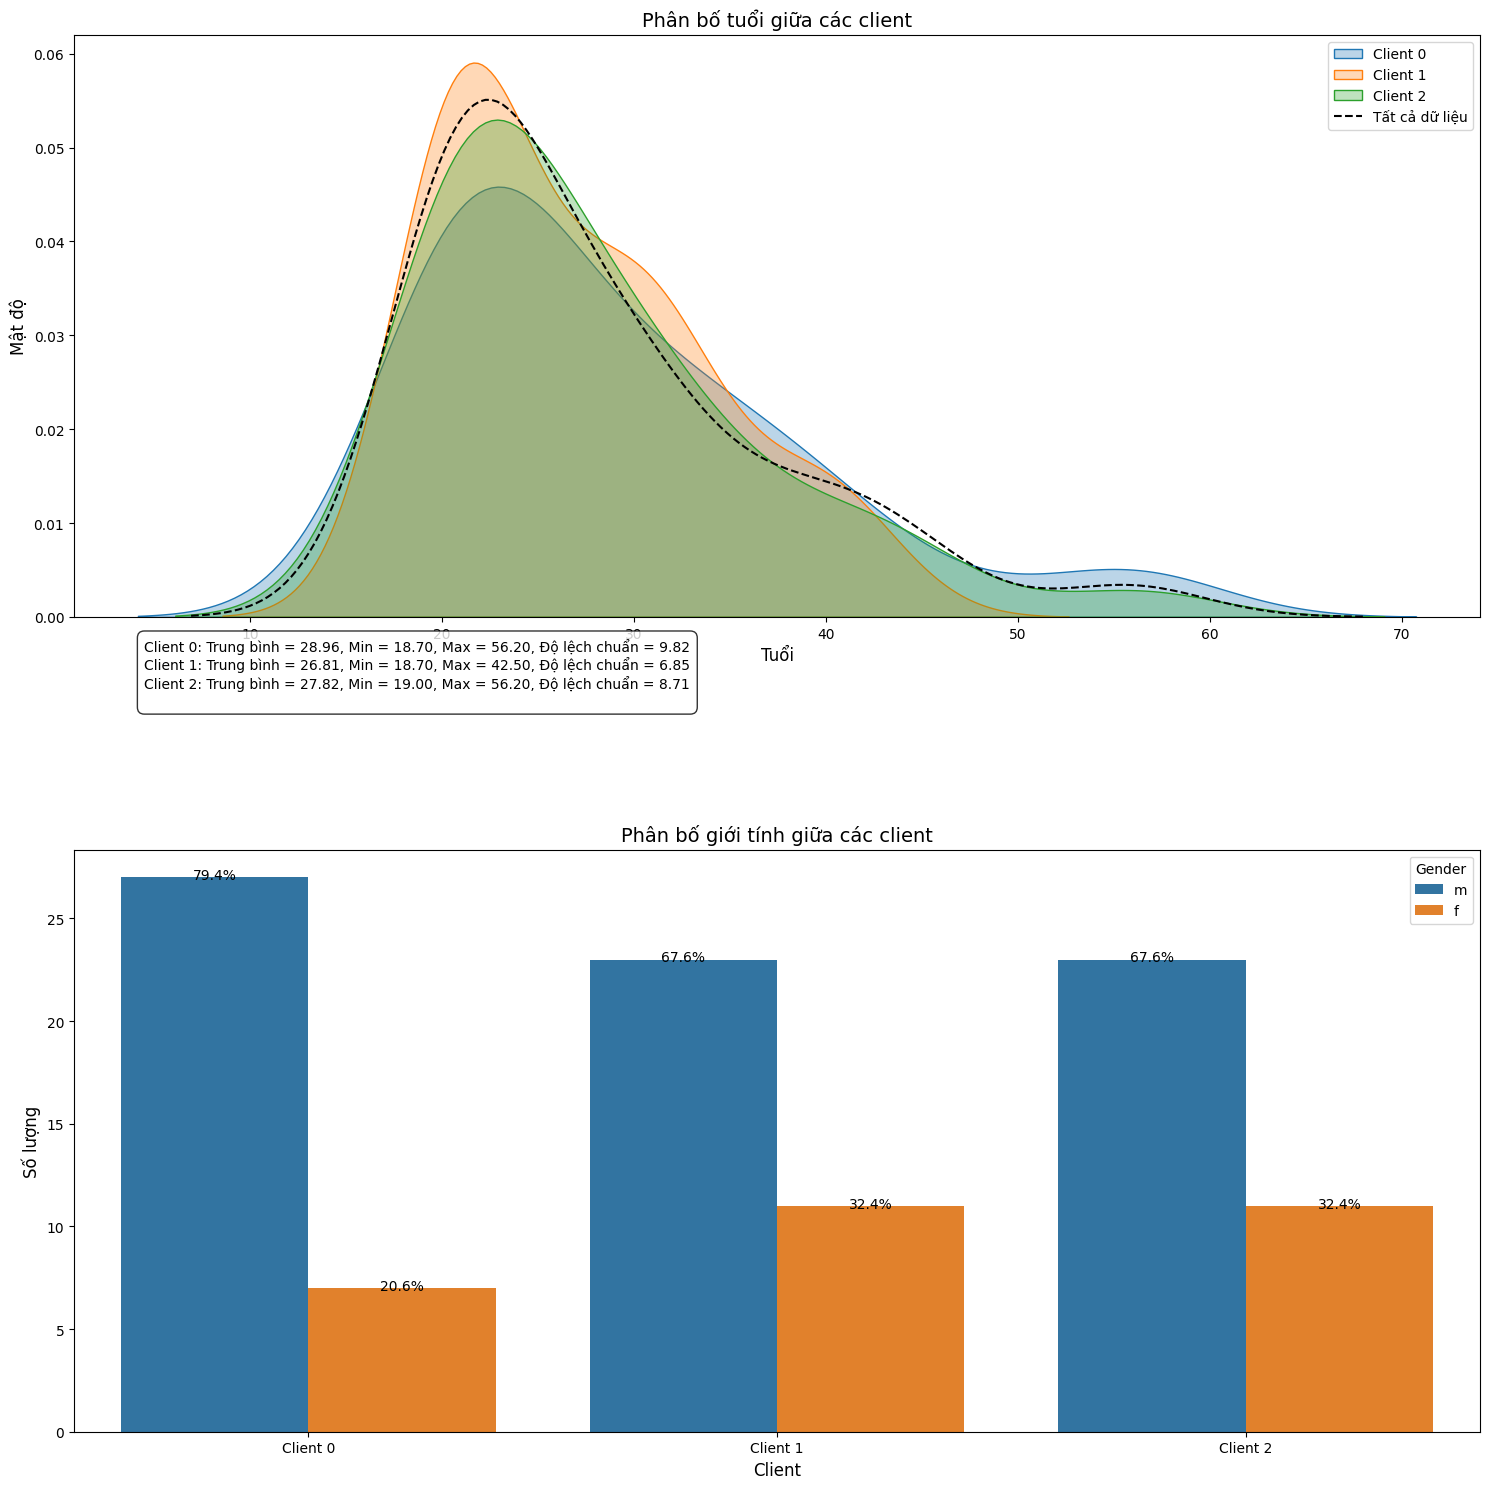

In [33]:
visualize_data_distribution(client_datasets)

In [34]:
client_datasets[0]

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
61,40.0,control,m,sub-BrainAge000063,ABIDE/CMU_b
57,27.0,pathology,m,sub-BrainAge000059,ABIDE/CMU_b
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
43,27.0,control,m,sub-BrainAge000045,ABIDE/CMU_a
5,37.7,pathology,m,sub-BrainAge000005,ABIDE/Caltech
36,33.0,pathology,m,sub-BrainAge000038,ABIDE/CMU_a
16,21.2,pathology,m,sub-BrainAge000017,ABIDE/Caltech
12,20.1,pathology,m,sub-BrainAge000012,ABIDE/Caltech
25,21.1,control,f,sub-BrainAge000026,ABIDE/Caltech
60,20.0,control,f,sub-BrainAge000062,ABIDE/CMU_b


# Sample Training with these distribution

In [35]:
# create sample dataset

def sample_dataset(dataset, sample_labels, val_ratio):

  client_datasets = []
  for label_df in sample_labels:
    dataset = MRIDataset(root_dir=ROOT_PATH, label_path=LABEL_PATH, label_df = label_df)
    train_size = (1 - val_ratio) * len(dataset)
    val_size = val_ratio * len(dataset)

    train_dataset, val_dataset = random_split(dataset, [1 - val_ratio, val_ratio])
    client_datasets.append((train_dataset, val_dataset))
  return client_datasets

In [36]:
full_dataset

In [37]:
client_datasets = sample_dataset(full_dataset, client_datasets, val_ratio= 0.2)

In [ ]:
import random
import numpy as np
from typing import Dict, List, Optional, Tuple, Union
import flwr as fl
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
)
from flwr.server.client_proxy import ClientProxy
from flwr.server.client_manager import ClientManager
from flwr.server.strategy import FedAvg
class DropoutFedAvg(FedAvg):

    def __init__(
        self,
        dropout_rate: float = 0.3,
        fixed_clients: Optional[List[int]] = None,
        dropout_pattern: str = "random",
        **kwargs
    ):
        if "fit_metrics_aggregation_fn" not in kwargs:
            kwargs["fit_metrics_aggregation_fn"] = self.weighted_average
        if "evaluate_metrics_aggregation_fn" not in kwargs:
            kwargs["evaluate_metrics_aggregation_fn"] = self.weighted_average

        super().__init__(**kwargs)
        self.dropout_rate = dropout_rate
        self.fixed_clients = fixed_clients or []
        self.dropout_pattern = dropout_pattern
        self.current_round = 0
        self.dropped_clients_history: Dict[int, List[int]] = {}

        self.fit_metrics_history: List[Dict[str, float]] = []
        self.eval_metrics_history: List[Dict[str, float]] = []

    def weighted_average(self, metrics: List[Tuple[int, Dict]]) -> Dict:
        if not metrics:
            return {}

        total_examples = sum([num_examples for num_examples, _ in metrics])
        weighted_metrics = {}

       
        for metric_key in metrics[0][1].keys():
            weighted_sum = sum(
                metric_dict[metric_key] * num_examples
                for num_examples, metric_dict in metrics
                if metric_key in metric_dict
            )
            weighted_metrics[metric_key] = weighted_sum / total_examples if total_examples > 0 else 0

        return weighted_metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        
        self.current_round = server_round

        # Get all clients and their fit instructions from parent class
        client_fit_instructions = super().configure_fit(
            server_round, parameters, client_manager
        )

        if not client_fit_instructions:
            return []

        available_clients = self._apply_dropout(client_fit_instructions)

        # Save dropout history for this round
        client_ids = [int(client.cid) for client, _ in client_fit_instructions]
        available_client_ids = [int(client.cid) for client, _ in available_clients]
        dropped_clients = [cid for cid in client_ids if cid not in available_client_ids]
        self.dropped_clients_history[server_round] = dropped_clients

        print(f"Round {server_round}: {len(dropped_clients)} clients dropped out of {len(client_ids)}")
        print(f"Dropped client IDs: {dropped_clients}")

        return available_clients

    def _apply_dropout(
        self, client_instructions: List[Tuple[ClientProxy, FitIns]]
    ) -> List[Tuple[ClientProxy, FitIns]]:
        if len(client_instructions) == 0:
            return []
        all_clients = [(client, ins) for client, ins in client_instructions]
        all_client_ids = [int(client.cid) for client, _ in all_clients]

    
        dropout_mask = [False] * len(all_clients)

        if self.dropout_pattern == "random":
            # Random dropout based on dropout_rate
            for i, cid in enumerate(all_client_ids):
                # Skip fixed clients
                if cid in self.fixed_clients:
                    continue
                # Apply dropout with probability dropout_rate
                if random.random() < self.dropout_rate:
                    dropout_mask[i] = True

        elif self.dropout_pattern == "alternate":
            # Dropout every other round
            if self.current_round % 2 == 1:  # Dropout on odd rounds
                for i, cid in enumerate(all_client_ids):
                    if cid not in self.fixed_clients:
                        dropout_mask[i] = True

        elif self.dropout_pattern == "fixed":
            # Always drop the same clients (first N% based on dropout_rate)
            n_dropout = int(len(all_clients) * self.dropout_rate)
            for i in range(n_dropout):
                if all_client_ids[i] not in self.fixed_clients:
                    dropout_mask[i] = True

        # Filter out dropped clients
        available_clients = [
            (client, ins) for i, (client, ins) in enumerate(all_clients)
            if not dropout_mask[i]
        ]

        return available_clients

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ):
        """Aggregate fit results and store metrics."""
        aggregated = super().aggregate_fit(server_round, results, failures)

        # Store metrics if available
        if results:
            # Extract and aggregate metrics
            metrics = [(res.num_examples, res.metrics) for _, res in results]
            aggregated_metrics = self.weighted_average(metrics)
            self.fit_metrics_history.append(aggregated_metrics)

            print(f"Round {server_round} training metrics: {aggregated_metrics}")

        return aggregated

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ):
        """Aggregate evaluation results and store metrics."""
        aggregated = super().aggregate_evaluate(server_round, results, failures)

        # Store metrics if available
        if results:
            # Extract and aggregate metrics
            metrics = [(res.num_examples, res.metrics) for _, res in results]
            aggregated_metrics = self.weighted_average(metrics)
            self.eval_metrics_history.append(aggregated_metrics)

            print(f"Round {server_round} evaluation metrics: {aggregated_metrics}")

        return aggregated

    def get_dropout_history(self) -> Dict[int, List[int]]:
        """Get the history of dropped clients by round."""
        return self.dropped_clients_history

    def get_metrics_history(self) -> Tuple[List[Dict[str, float]], List[Dict[str, float]]]:
        """Get the history of training and evaluation metrics."""
        return self.fit_metrics_history, self.eval_metrics_history

In [ ]:
from flwr.client import ClientApp
from flwr.server import ServerApp
from flwr.simulation import run_simulation
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
import os

def run_dropout_experiment(
    client_fn,
    num_clients: int,
    num_rounds: int = 5,
    dropout_rate: float = 0.3,
    dropout_pattern: str = "random",
    fixed_clients: Optional[List[int]] = None,
    experiment_name: str = "dropout_experiment",
    save_results: bool = True,
):
    
    print(f"\nStarting experiment: {experiment_name}")
    print(f"Dropout rate: {dropout_rate}, Pattern: {dropout_pattern}")
    print(f"Fixed clients: {fixed_clients or []}")

    # Create strategy with dropout
    strategy = DropoutFedAvg(
        dropout_rate=dropout_rate,
        dropout_pattern=dropout_pattern,
        fixed_clients=fixed_clients or [],
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=1,
    )

    # Configure server with strategy
    def server_fn(server_context: Context):
        from flwr.server import ServerAppComponents, ServerConfig
        config = ServerConfig(num_rounds=num_rounds)
        return ServerAppComponents(strategy=strategy, config=config)

    # Create client and server apps
    client_app = ClientApp(client_fn=client_fn)
    server_app = ServerApp(server_fn=server_fn)

    # Configure backend
    backend_config = {
        "client_resources": {
            "num_cpus": 1,
            "num_gpus": 0.0
        }
    }
    history = strategy.get_dropout_history()
    # Run simulation
    try:
        run_simulation(
            client_app=client_app,
            server_app=server_app,
            num_supernodes=num_clients,
            backend_config=backend_config,
        )

        # Get metrics directly from strategy
        fit_metrics, eval_metrics = strategy.get_metrics_history()
        dropout_history = strategy.get_dropout_history()

        # Format metrics for plotting
        rounds = list(range(1, len(eval_metrics) + 1))
        accuracy_values = [metrics.get("accuracy", 0.0) for metrics in eval_metrics]
        loss_values = [metrics.get("loss", 0.0) for metrics in eval_metrics]


        results = {
            "rounds": rounds,
            "accuracy": accuracy_values,
            "loss": loss_values,
            "dropout_history": dropout_history
        }

        # Visualize results
        plt.figure(figsize=(15, 7))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(rounds, accuracy_values, 'o-', label=f'{dropout_pattern} dropout')
        plt.title(f'Accuracy with {dropout_rate*100:.0f}% Dropout')
        plt.xlabel('Round')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.ylim(0, 1)

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(rounds, loss_values, 'o-', color='orange', label=f'{dropout_pattern} dropout')
        plt.title(f'Loss with {dropout_rate*100:.0f}% Dropout')
        plt.xlabel('Round')
        plt.ylabel('Loss')
        plt.grid(True)

        plt.tight_layout()

        if save_results:
            # Create results directory
            os.makedirs("results", exist_ok=True)

            # Save figure
            plt.savefig(f"results/{experiment_name}.png")

            # Save metrics to CSV
            metrics_df = pd.DataFrame({
                "round": rounds,
                "accuracy": accuracy_values,
                "loss": loss_values
            })
            metrics_df.to_csv(f"results/{experiment_name}_metrics.csv", index=False)

            # Save dropout history
            dropout_df = pd.DataFrame([
                {"round": round_num, "dropped_clients": ",".join(map(str, clients))}
                for round_num, clients in dropout_history.items()
            ])
            dropout_df.to_csv(f"results/{experiment_name}_dropout.csv", index=False)

        plt.show()

        return results, history
    except Exception as e:
        print(f"Error in dropout experiment: {e}")
        import traceback
        traceback.print_exc()
        return {"error": str(e)}

In [ ]:

def conduct_dropout_experiments(client_fn, num_clients=3, num_rounds=5):
    """Run a series of experiments with different dropout configurations."""

    # Experiment 1: Random dropout with 30% rate
    exp1_results, exp1_history = run_dropout_experiment(
        client_fn=client_fn,
        num_clients=num_clients,
        num_rounds=num_rounds,
        dropout_rate=0.3,
        dropout_pattern="random",
        experiment_name="random_dropout_30pct"
    )

    # Experiment 2: Alternate dropout (every other round)
    exp2_results, exp2_history = run_dropout_experiment(
        client_fn=client_fn,
        num_clients=num_clients,
        num_rounds=num_rounds,
        dropout_pattern="alternate",
        experiment_name="alternate_dropout"
    )

    # Experiment 3: Fixed dropout (same clients always drop out)
    exp3_results, exp3_history = run_dropout_experiment(
        client_fn=client_fn,
        num_clients=num_clients,
        num_rounds=num_rounds,
        dropout_rate=0.3,
        dropout_pattern="fixed",
        experiment_name="fixed_dropout_30pct"
    )

    # Experiment 4: High dropout rate (70%)
    exp4_results, exp4_history = run_dropout_experiment(
        client_fn=client_fn,
        num_clients=num_clients,
        num_rounds=num_rounds,
        dropout_rate=0.7,
        dropout_pattern="random",
        experiment_name="random_dropout_70pct"
    )

    # Experiment 5: With fixed clients that never drop out
    exp5_results, exp5_history = run_dropout_experiment(
        client_fn=client_fn,
        num_clients=num_clients,
        num_rounds=num_rounds,
        dropout_rate=0.5,
        dropout_pattern="random",
        fixed_clients=[0],  # Client 0 never drops out
        experiment_name="random_dropout_with_fixed"
    )

    return {
        "random_30pct": (exp1_results, exp1_history),
        "alternate": (exp2_results, exp2_history),
        "fixed_30pct": (exp3_results, exp3_history),
        "random_70pct": (exp4_results, exp4_history),
        "random_with_fixed": (exp5_results, exp5_history)
    }


In [ ]:
def client_func(context: Context):
    client_id = context.node_config['partition-id']
    train_dataset, val_dataset = client_datasets[client_id]

    train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 2)
    val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 2)

    model = BrainMRINet(num_classes = 2)
    model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.CrossEntropyLoss()
    return FlowerClient(model, train_dataloader, val_dataloader, optimizer, criterion, EPOCHS, DEVICE).to_client()

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]



Starting experiment: random_dropout_30pct
Dropout rate: 0.3, Pattern: random
Fixed clients: []


INFO :      Requesting initial parameters from one random client
(pid=72968) 2025-05-01 12:45:16.261962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=72968) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=72968) E0000 00:00:1746103516.319656   72968 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=72968) E0000 00:00:1746103516.337285   72968 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit:

Round 1: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=72968) Epoch 1/5
(ClientAppActor pid=72968) Train - Loss: 2.5271, Accuracy: 0.7500
(ClientAppActor pid=72968) Epoch 2/5
(ClientAppActor pid=72968) Train - Loss: 2.9731, Accuracy: 0.8571
(ClientAppActor pid=72968) Epoch 3/5
(ClientAppActor pid=72967) Epoch 1/5
(ClientAppActor pid=72968) Train - Loss: 2.1983, Accuracy: 0.7500
(ClientAppActor pid=72967) Train - Loss: 6.8484, Accuracy: 0.6071
(ClientAppActor pid=72967) Epoch 2/5 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=72968) Train - Loss: 7.3729, Accuracy: 0.6071 [repeated 3x across cluster]
(ClientAppActor pid=72967) Epoch 3/5 [repeated 2x across cluster]
(ClientAppActor pid=72968) Train - Loss: 3.8776, Accuracy: 0.8077 [repeated 4x across clu

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=72968) Train - Loss: 2.6294, Accuracy: 0.8462 [repeated 4x across cluster]
(ClientAppActor pid=72968) Epoch 5/5 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 1 training metrics: {'loss': 4.047394734312444, 'accuracy': 0.7317073170731707}
(ClientAppActor pid=72967) Test - Loss: 0.2183, Accuracy: 0.8333


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 1 evaluation metrics: {'accuracy': 0.6666666666666666, 'loss': 0.934244304895401}
Round 2: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=72968) Train - Loss: 1.9271, Accuracy: 0.8929
(ClientAppActor pid=72968) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=72967) Test - Loss: 2.4573, Accuracy: 0.3333 [repeated 2x across cluster]
(ClientAppActor pid=72967) Train - Loss: 0.1503, Accuracy: 0.8929
(ClientAppActor pid=72968) Epoch 4/5 [repeated 4x across cluster]
(ClientAppActor pid=72968) Train - Loss: 2.2133, Accuracy: 0.7143 [repeated 3x across cluster]
(ClientAppActor pid=72967) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.5018, Accuracy: 0.8571 [repeated 4x across cluster]
(ClientAppActor pid=72968) Epoch 3/5 [repeated 3x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.6206, Accuracy: 0.9231 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=72968) Epoch 5/5 [repeated 2x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.5283, Accuracy: 0.8462 [repeated 3x across cluster]


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 2 training metrics: {'loss': 1.0575288118560315, 'accuracy': 0.8536585365853658}
(ClientAppActor pid=72967) Test - Loss: 0.5173, Accuracy: 0.6667


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 2 evaluation metrics: {'accuracy': 0.6111111111111112, 'loss': 1.3675754516540717}
Round 3: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=72968) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.7923, Accuracy: 0.7857
(ClientAppActor pid=72967) Train - Loss: 0.5623, Accuracy: 0.8929
(ClientAppActor pid=72967) Train - Loss: 0.3757, Accuracy: 0.8929
(ClientAppActor pid=72967) Test - Loss: 3.0941, Accuracy: 0.5000 [repeated 2x across cluster]
(ClientAppActor pid=72968) Epoch 4/5 [repeated 4x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.7662, Accuracy: 0.7857 [repeated 2x across cluster]
(ClientAppActor pid=72968) Epoch 5/5 [repeated 2x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.3798, Accuracy: 0.8929 [repeated 2x across cluster]
(ClientAppActor pid=72968) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.0474, Accuracy: 1.0000 [repeated 4x across cluster]
(ClientAppA

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 3 training metrics: {'loss': 0.9453680264939469, 'accuracy': 0.8902439024390244}
(ClientAppActor pid=72968) Test - Loss: 0.0508, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 1 clients (out of 3)


Round 3 evaluation metrics: {'accuracy': 0.8888888888888888, 'loss': 1.4047272787011025}
Round 4: 2 clients dropped out of 3
Dropped client IDs: [10965053413725839383, 5368621208324208212]
(ClientAppActor pid=72967) Epoch 2/5 [repeated 2x across cluster]
(ClientAppActor pid=72967) Train - Loss: 0.1532, Accuracy: 0.8929 [repeated 2x across cluster]
(ClientAppActor pid=72967) Test - Loss: 4.0604, Accuracy: 0.6667 [repeated 2x across cluster]
(ClientAppActor pid=72967) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=72967) Train - Loss: 0.1512, Accuracy: 0.9286 [repeated 3x across cluster]


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 4 training metrics: {'loss': 0.8083071112617759, 'accuracy': 0.8928571428571429}
(ClientAppActor pid=72968) Test - Loss: 9.0152, Accuracy: 0.5000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 4 evaluation metrics: {'accuracy': 0.5, 'loss': 11.024837692578634}
Round 5: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=72967) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=72967) Train - Loss: 2.6413, Accuracy: 0.8571 [repeated 2x across cluster]
(ClientAppActor pid=72968) Test - Loss: 16.6812, Accuracy: 0.5000 [repeated 2x across cluster]
(ClientAppActor pid=72968) Epoch 3/5 [repeated 3x across cluster]
(ClientAppActor pid=72968) Train - Loss: 0.0926, Accuracy: 0.9643 [repeated 3x across cluster]
(ClientAppActor pid=72967) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=72967) Train - Loss: 0.0207, Accuracy: 1.0000 [repeated 3x across cluster]
(ClientAppActor pid=72967) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=72967) Train - Loss: 0.5270, Accuracy: 0.9231 [repeated 4x across cluster]
(ClientAppActor pid=72967) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=72967) Train - Loss: 2.5202, Accuracy: 0.8

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 5 training metrics: {'loss': 0.4037747258028297, 'accuracy': 0.926829268292683}
(ClientAppActor pid=72968) Test - Loss: 0.0000, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 154.37s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.934244304895401
INFO :      		round 2: 1.3675754516540717
INFO :      		round 3: 1.4047272787011025
INFO :      		round 4: 11.024837692578634
INFO :      		round 5: 0.8816277861022854
INFO :      	History (metrics, distributed, fit):
INFO :      	{'accuracy': [(1, 0.7317073170731707),
INFO :      	              (2, 0.8536585365853658),
INFO :      	              (3, 0.8902439024390244),
INFO :      	              (4, 0.8928571428571429),
INFO :      	              (5, 0.926829268292683)],
INFO :      	 'loss': [(1, 4.047394734312444),
INFO :      	          (2, 1.0575288118560315),
INFO :      	          (3, 0.9453680264939469),
INFO :      	          (4, 0.8083071112617759),
INFO :      	          (5, 0.4037747258028297)]}
INFO :      	History (metrics, distributed, evaluat

Round 5 evaluation metrics: {'accuracy': 0.8888888888888888, 'loss': 0.8816277861022854}
(ClientAppActor pid=72967) Train - Loss: 0.3637, Accuracy: 0.9231
(ClientAppActor pid=72968) Test - Loss: 2.6449, Accuracy: 0.6667 [repeated 2x across cluster]


(pid=72967) 2025-05-01 12:45:16.265064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=72967) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=72967) E0000 00:00:1746103516.319656   72967 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=72967) E0000 00:00:1746103516.337299   72967 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


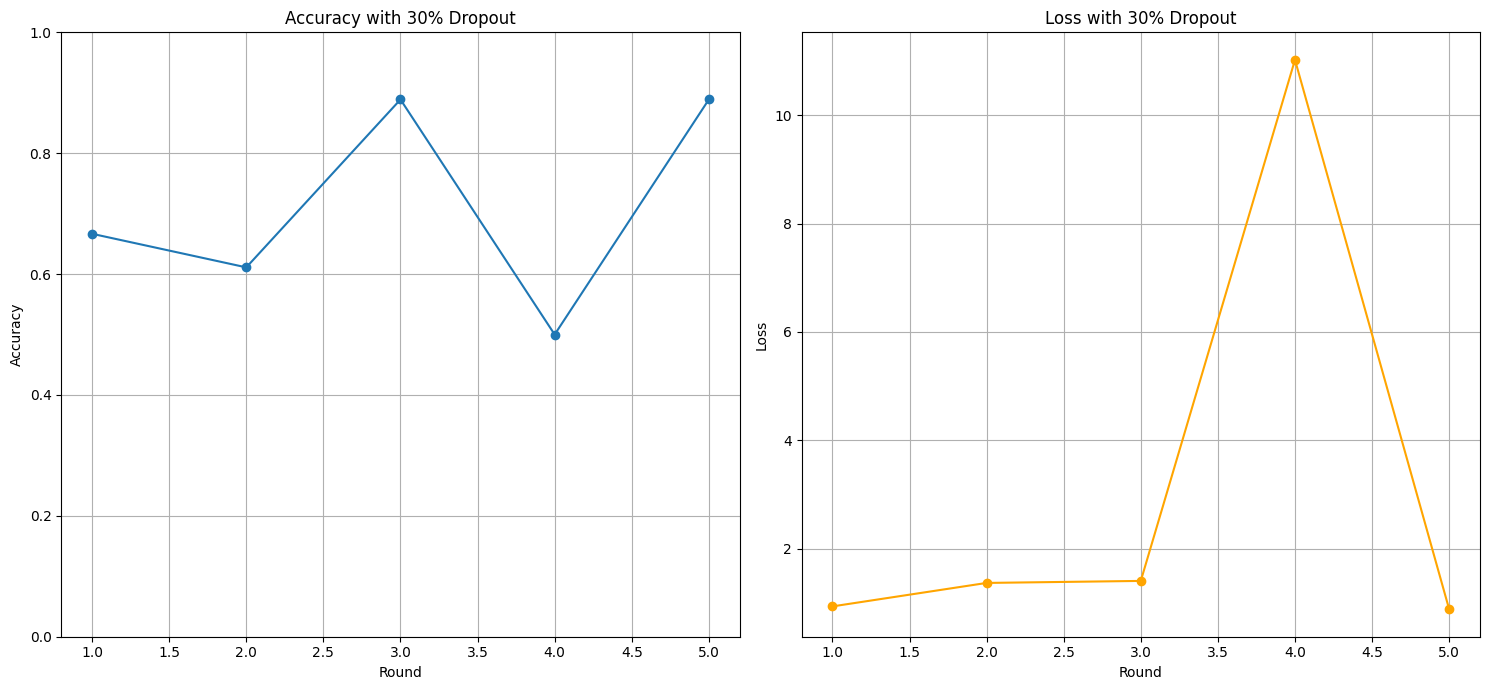

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client



Starting experiment: alternate_dropout
Dropout rate: 0.3, Pattern: alternate
Fixed clients: []


(pid=74660) 2025-05-01 12:48:15.846304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=74660) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=74660) E0000 00:00:1746103695.888730   74660 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=74660) E0000 00:00:1746103695.900988   74660 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: no clients selected, cancel
INFO :      configure_evaluate: stra

Round 1: 3 clients dropped out of 3
Dropped client IDs: [6539324092955767321, 16740681463706336601, 15719824639187665150]
(ClientAppActor pid=74660) Test - Loss: 2.8192, Accuracy: 0.5000
(ClientAppActor pid=74660) Test - Loss: 1.5057, Accuracy: 0.5000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 1 evaluation metrics: {'accuracy': 0.4444444444444444, 'loss': 2.4977981920043626}
Round 2: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=74660) Epoch 1/5
(ClientAppActor pid=74658) Test - Loss: 3.1686, Accuracy: 0.3333
(ClientAppActor pid=74660) Train - Loss: 8.7867, Accuracy: 0.6786
(ClientAppActor pid=74660) Epoch 3/5 [repeated 4x across cluster]
(ClientAppActor pid=74660) Train - Loss: 3.7073, Accuracy: 0.6786 [repeated 4x across cluster]
(ClientAppActor pid=74660) Epoch 5/5 [repeated 4x across cluster]
(ClientAppActor pid=74658) Train - Loss: 3.8320, Accuracy: 0.8571 [repeated 3x across cluster]
(ClientAppActor pid=74660) Epoch 1/5 [repeated 2x across cluster]
(ClientAppActor pid=74660) Train - Loss: 0.8897, Accuracy: 0.8077 [repeated 4x across cluster]
(ClientAppActor pid=74660) Epoch 5/5 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=74660) Train - Loss: 1.7071, Accuracy: 0.7308 [repeated 3x across cluster]


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 2 training metrics: {'loss': 1.691015459999496, 'accuracy': 0.7804878048780488}
(ClientAppActor pid=74658) Test - Loss: 1.7827, Accuracy: 0.6667


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: no clients selected, cancel
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 2 evaluation metrics: {'accuracy': 0.6666666666666666, 'loss': 2.1143127965430417}
Round 3: 3 clients dropped out of 3
Dropped client IDs: [16740681463706336601, 6539324092955767321, 15719824639187665150]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 3 evaluation metrics: {'accuracy': 0.6666666666666666, 'loss': 2.1143127965430417}
Round 4: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=74658) Epoch 1/5
(ClientAppActor pid=74658) Train - Loss: 2.1516, Accuracy: 0.7143
(ClientAppActor pid=74660) Test - Loss: 3.9331, Accuracy: 0.5000 [repeated 5x across cluster]
(ClientAppActor pid=74660) Train - Loss: 3.5881, Accuracy: 0.8571
(ClientAppActor pid=74658) Epoch 3/5 [repeated 4x across cluster]
(ClientAppActor pid=74660) Train - Loss: 0.1102, Accuracy: 0.9286 [repeated 3x across cluster]
(ClientAppActor pid=74660) Epoch 4/5 [repeated 2x across cluster]
(ClientAppActor pid=74658) Train - Loss: 0.0774, Accuracy: 0.9286 [repeated 4x across cluster]
(ClientAppActor pid=74658) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=74658) Train - Loss: 1.7441, Accuracy: 0.7692 [repeated 3x across cluster]
(ClientAppActor pid=74658) Epoch 3/5 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=74658) Train - Loss: 0.3318, Accuracy: 0.9231 [repeated 3x across cluster]
(ClientAppActor pid=74658) Epoch 5/5 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 4 training metrics: {'loss': 0.6302515392598037, 'accuracy': 0.8902439024390244}
(ClientAppActor pid=74658) Test - Loss: 0.2692, Accuracy: 0.8333


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: no clients selected, cancel
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 4 evaluation metrics: {'accuracy': 0.6666666666666666, 'loss': 1.4733899431303144}
Round 5: 3 clients dropped out of 3
Dropped client IDs: [16740681463706336601, 6539324092955767321, 15719824639187665150]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 74.77s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.4977981920043626
INFO :      		round 2: 2.1143127965430417
INFO :      		round 3: 2.1143127965430417
INFO :      		round 4: 1.4733899431303144
INFO :      		round 5: 1.4733899431303144
INFO :      	History (metrics, distributed, fit):
INFO :      	{'accuracy': [(2, 0.7804878048780488), (4, 0.8902439024390244)],
INFO :      	 'loss': [(2, 1.691015459999496), (4, 0.6302515392598037)]}
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.4444444444444444),
INFO :      	              (2, 0.6666666666666666),
INFO :      	              (3, 0.6666666666666666),
INFO :      	              (4, 0.6666666666666666),
INFO :      	              (5, 0.6666666666666666)],
INFO :      	 'loss': [(1, 2.4977981920043626),
INFO :      	          (2, 2.1143127

Round 5 evaluation metrics: {'accuracy': 0.6666666666666666, 'loss': 1.4733899431303144}
(ClientAppActor pid=74658) Test - Loss: 3.3602, Accuracy: 0.5000 [repeated 5x across cluster]


(pid=74658) 2025-05-01 12:48:15.914443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=74658) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=74658) E0000 00:00:1746103695.954846   74658 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=74658) E0000 00:00:1746103695.969370   74658 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


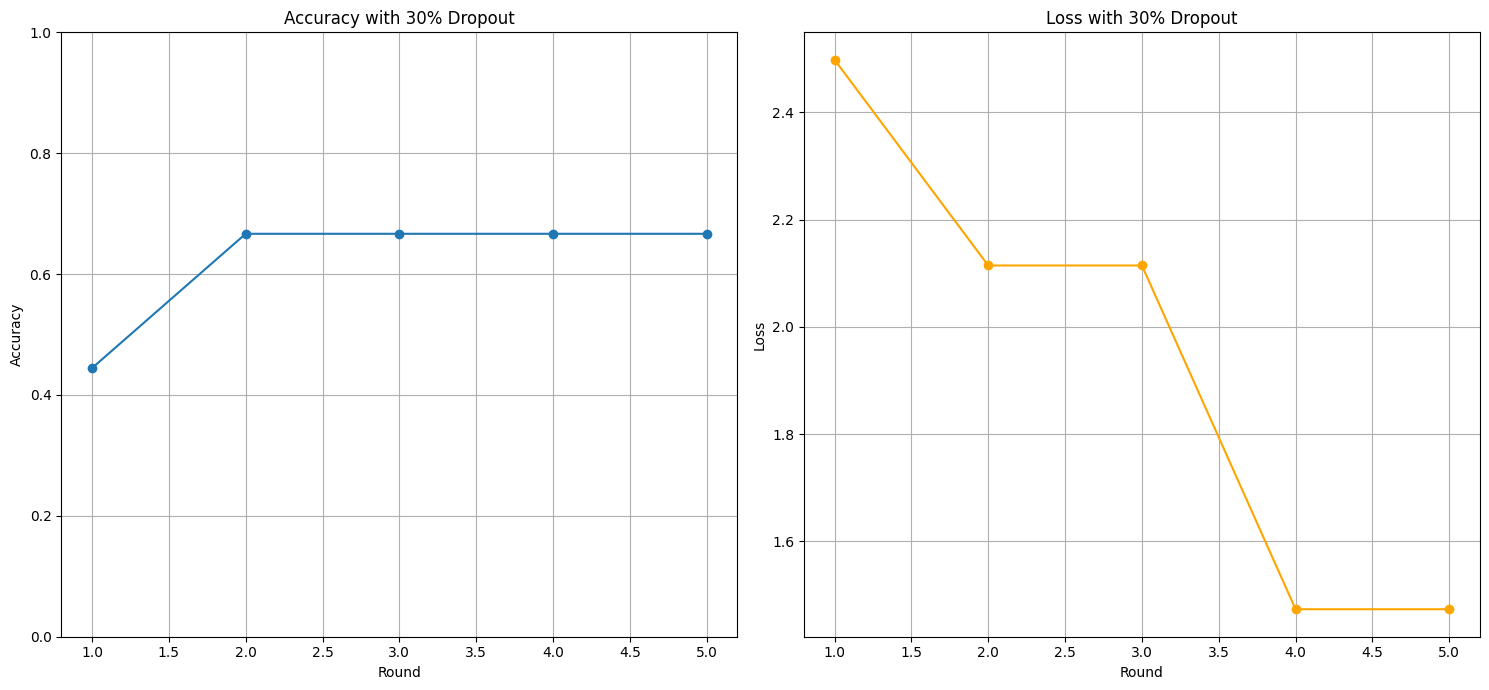

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client



Starting experiment: fixed_dropout_30pct
Dropout rate: 0.3, Pattern: fixed
Fixed clients: []


(pid=75711) 2025-05-01 12:49:55.144941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=75711) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=75711) E0000 00:00:1746103795.190593   75711 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=75711) E0000 00:00:1746103795.204694   75711 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 1: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=75712) Epoch 1/5
(ClientAppActor pid=75712) Train - Loss: 7.9059, Accuracy: 0.7500
(ClientAppActor pid=75712) Epoch 2/5
(ClientAppActor pid=75712) Train - Loss: 4.0200, Accuracy: 0.5714
(ClientAppActor pid=75712) Epoch 3/5
(ClientAppActor pid=75711) Epoch 1/5
(ClientAppActor pid=75712) Train - Loss: 3.4921, Accuracy: 0.8571
(ClientAppActor pid=75712) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=75712) Train - Loss: 1.4384, Accuracy: 0.8214 [repeated 4x across cluster]
(ClientAppActor pid=75712) Epoch 2/5 [repeated 4x across cluster]
(ClientAppActor pid=75712) Train - Loss: 7.9911, Accuracy: 0.6154 [repeated 2x across cluster]
(ClientAppActor pid=75712) Epoch 4/5 [repeated 3x across cluster]
(ClientAppActor pid=75712) Train - Loss: 3.3437, Accuracy: 0.6923 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 1 training metrics: {'loss': 2.2170983800807758, 'accuracy': 0.7926829268292683}
(ClientAppActor pid=75711) Test - Loss: 2.6448, Accuracy: 0.5000
(ClientAppActor pid=75712) Epoch 5/5
(ClientAppActor pid=75712) Train - Loss: 3.2495, Accuracy: 0.7692 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 1 evaluation metrics: {'accuracy': 0.5, 'loss': 2.781164325773716}
Round 2: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=75711) Epoch 1/5
(ClientAppActor pid=75712) Test - Loss: 4.6186, Accuracy: 0.5000 [repeated 2x across cluster]
(ClientAppActor pid=75711) Train - Loss: 1.5611, Accuracy: 0.7143
(ClientAppActor pid=75712) Train - Loss: 1.6930, Accuracy: 0.8214
(ClientAppActor pid=75711) Epoch 3/5 [repeated 4x across cluster]
(ClientAppActor pid=75711) Train - Loss: 2.7489, Accuracy: 0.7143 [repeated 3x across cluster]
(ClientAppActor pid=75711) Epoch 5/5 [repeated 4x across cluster]
(ClientAppActor pid=75712) Train - Loss: 1.6674, Accuracy: 0.7857 [repeated 3x across cluster]
(ClientAppActor pid=75711) Epoch 1/5 [repeated 2x across cluster]
(ClientAppActor pid=75711) Train - Loss: 1.6418, Accuracy: 0.8462 [repeated 3x across cluster]
(ClientAppActor pid=75711) Epoch 4/5 [repeated 3x across cluster]
(ClientAppActor pid=75711) Train - Loss: 1.8488, Accurac

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 2 training metrics: {'loss': 0.3265085222225298, 'accuracy': 0.9146341463414634}
(ClientAppActor pid=75711) Test - Loss: 0.3086, Accuracy: 0.6667
(ClientAppActor pid=75711) Epoch 5/5


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=75711) Train - Loss: 0.2410, Accuracy: 0.9231
Round 2 evaluation metrics: {'accuracy': 0.6111111111111112, 'loss': 0.957730662698547}
Round 3: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=75711) Epoch 1/5
(ClientAppActor pid=75712) Train - Loss: 0.9121, Accuracy: 0.7143
(ClientAppActor pid=75711) Test - Loss: 2.2110, Accuracy: 0.5000 [repeated 2x across cluster]
(ClientAppActor pid=75712) Epoch 3/5 [repeated 4x across cluster]
(ClientAppActor pid=75712) Train - Loss: 0.5357, Accuracy: 0.8929 [repeated 4x across cluster]
(ClientAppActor pid=75711) Epoch 4/5 [repeated 3x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.4798, Accuracy: 0.8929 [repeated 3x across cluster]
(ClientAppActor pid=75711) Epoch 5/5 [repeated 2x across cluster]
(ClientAppActor pid=75712) Train - Loss: 0.0333, Accuracy: 1.0000 [repeated 3x across cluster]
(ClientAppActor pid=75712) Epoch 4/5 [repeated 4x across cluster]
(ClientAppActor pid=75712) Train - Loss: 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 3 training metrics: {'loss': 0.684954385437491, 'accuracy': 0.8658536585365854}
(ClientAppActor pid=75711) Test - Loss: 0.0346, Accuracy: 1.0000
(ClientAppActor pid=75712) Epoch 5/5
(ClientAppActor pid=75712) Train - Loss: 0.4088, Accuracy: 0.9231 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 3 evaluation metrics: {'accuracy': 0.8888888888888888, 'loss': 1.140742932271678}
Round 4: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=75711) Epoch 1/5
(ClientAppActor pid=75711) Test - Loss: 3.3782, Accuracy: 0.6667 [repeated 2x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.2813, Accuracy: 0.9643 [repeated 3x across cluster]
(ClientAppActor pid=75711) Epoch 3/5 [repeated 4x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.1755, Accuracy: 0.9643 [repeated 4x across cluster]
(ClientAppActor pid=75711) Epoch 5/5 [repeated 4x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.1965, Accuracy: 0.9231 [repeated 4x across cluster]
(ClientAppActor pid=75711) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.7101, Accuracy: 0.9231 [repeated 3x across cluster]
(ClientAppActor pid=75711) Epoch 5/5 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 4 training metrics: {'loss': 0.3066342396075487, 'accuracy': 0.9512195121951219}
(ClientAppActor pid=75711) Test - Loss: 0.0011, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Round 4 evaluation metrics: {'accuracy': 0.8888888888888888, 'loss': 0.8551181116642207}
Round 5: 0 clients dropped out of 3
Dropped client IDs: []
(ClientAppActor pid=75712) Train - Loss: 0.4205, Accuracy: 0.8571 [repeated 2x across cluster]
(ClientAppActor pid=75712) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=75711) Test - Loss: 2.5610, Accuracy: 0.6667 [repeated 2x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.9379, Accuracy: 0.9286 [repeated 4x across cluster]
(ClientAppActor pid=75711) Epoch 4/5 [repeated 4x across cluster]
(ClientAppActor pid=75712) Train - Loss: 0.4928, Accuracy: 0.9286 [repeated 3x across cluster]
(ClientAppActor pid=75712) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.0070, Accuracy: 1.0000 [repeated 3x across cluster]
(ClientAppActor pid=75711) Epoch 2/5 [repeated 2x across cluster]
(ClientAppActor pid=75711) Train - Loss: 0.0013, Accuracy: 1.0000 [repeated 3x across cluster]
(ClientAppActor pid

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 5 training metrics: {'loss': 0.08550474832297852, 'accuracy': 0.9878048780487805}
(ClientAppActor pid=75712) Test - Loss: 0.0487, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 173.11s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.781164325773716
INFO :      		round 2: 0.957730662698547
INFO :      		round 3: 1.140742932271678
INFO :      		round 4: 0.8551181116642207
INFO :      		round 5: 1.9870343997786222
INFO :      	History (metrics, distributed, fit):
INFO :      	{'accuracy': [(1, 0.7926829268292683),
INFO :      	              (2, 0.9146341463414634),
INFO :      	              (3, 0.8658536585365854),
INFO :      	              (4, 0.9512195121951219),
INFO :      	              (5, 0.9878048780487805)],
INFO :      	 'loss': [(1, 2.2170983800807758),
INFO :      	          (2, 0.3265085222225298),
INFO :      	          (3, 0.684954385437491),
INFO :      	          (4, 0.3066342396075487),
INFO :      	          (5, 0.08550474832297852)]}
INFO :      	History (metrics, distributed, evaluat

Round 5 evaluation metrics: {'accuracy': 0.8888888888888888, 'loss': 1.9870343997786222}
(ClientAppActor pid=75711) Train - Loss: 0.0077, Accuracy: 1.0000
(ClientAppActor pid=75712) Test - Loss: 5.8910, Accuracy: 0.6667 [repeated 2x across cluster]


(pid=75712) 2025-05-01 12:49:55.159571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=75712) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=75712) E0000 00:00:1746103795.203782   75712 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=75712) E0000 00:00:1746103795.216460   75712 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


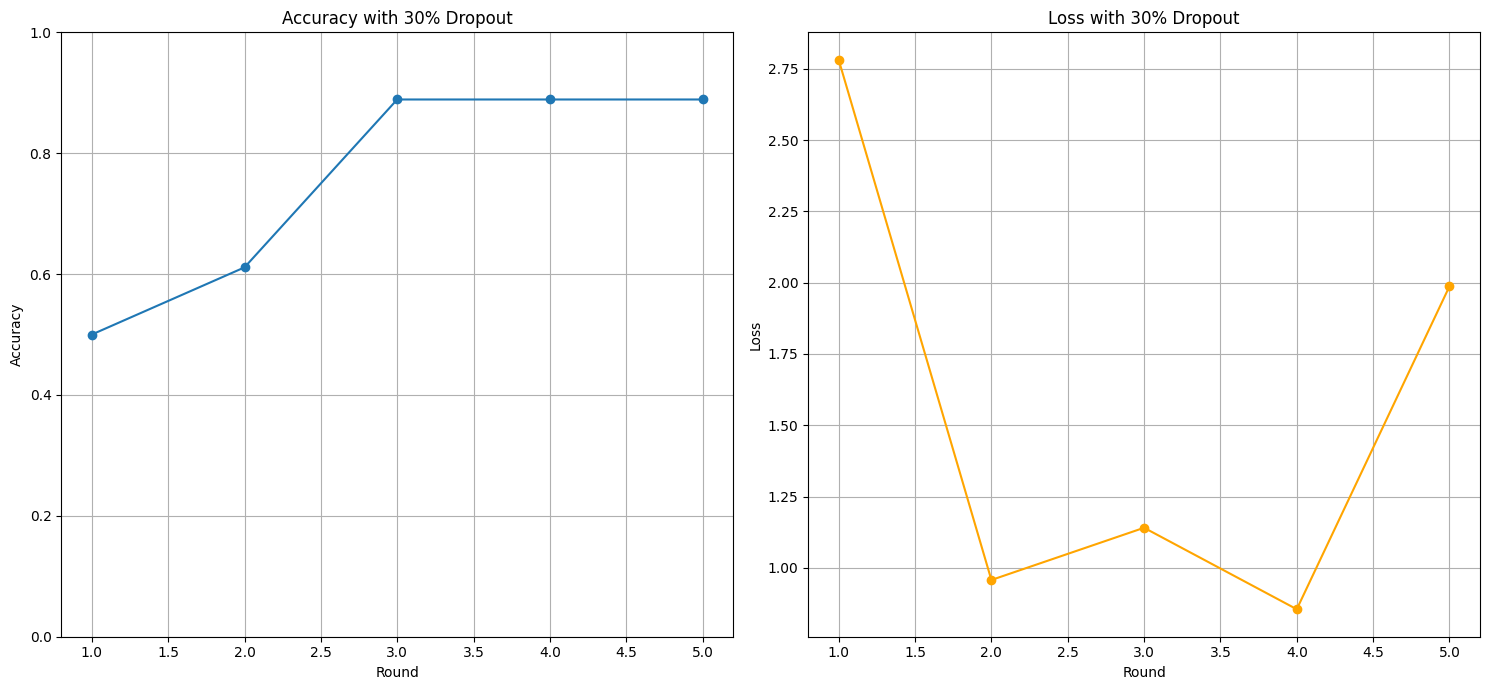

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client



Starting experiment: random_dropout_70pct
Dropout rate: 0.7, Pattern: random
Fixed clients: []


(pid=77528) 2025-05-01 12:53:14.431364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=77528) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=77528) E0000 00:00:1746103994.474898   77528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=77528) E0000 00:00:1746103994.487382   77528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: no clients selected, cancel
INFO :      configure_evaluate: stra

Round 1: 3 clients dropped out of 3
Dropped client IDs: [18376772018631056738, 10195778649471883292, 6076288407146118624]
(ClientAppActor pid=77528) Test - Loss: 2.0155, Accuracy: 0.5000
(ClientAppActor pid=77528) Test - Loss: 2.5125, Accuracy: 0.5000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 1 clients (out of 3)


Round 1 evaluation metrics: {'accuracy': 0.5555555555555556, 'loss': 2.1055227369070053}
Round 2: 2 clients dropped out of 3
Dropped client IDs: [10195778649471883292, 18376772018631056738]
(ClientAppActor pid=77527) Epoch 1/5
(ClientAppActor pid=77527) Test - Loss: 1.7886, Accuracy: 0.6667
(ClientAppActor pid=77527) Train - Loss: 3.6720, Accuracy: 0.5714
(ClientAppActor pid=77527) Epoch 2/5
(ClientAppActor pid=77527) Train - Loss: 5.1009, Accuracy: 0.7143
(ClientAppActor pid=77527) Epoch 3/5
(ClientAppActor pid=77527) Train - Loss: 5.4760, Accuracy: 0.5714
(ClientAppActor pid=77527) Epoch 4/5
(ClientAppActor pid=77527) Train - Loss: 3.4902, Accuracy: 0.7500
(ClientAppActor pid=77527) Epoch 5/5


INFO :      aggregate_fit: received 1 results and 0 failures


(ClientAppActor pid=77527) Train - Loss: 1.2459, Accuracy: 0.7857


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 2 training metrics: {'loss': 1.245868012120809, 'accuracy': 0.7857142857142857}
(ClientAppActor pid=77528) Test - Loss: 1.0979, Accuracy: 0.6667


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: no clients selected, cancel
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 2 evaluation metrics: {'accuracy': 0.6111111111111112, 'loss': 1.4518684878324468}
Round 3: 3 clients dropped out of 3
Dropped client IDs: [18376772018631056738, 6076288407146118624, 10195778649471883292]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: no clients selected, cancel
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 3 evaluation metrics: {'accuracy': 0.6111111111111112, 'loss': 1.4518684878324468}
Round 4: 3 clients dropped out of 3
Dropped client IDs: [18376772018631056738, 6076288407146118624, 10195778649471883292]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: no clients selected, cancel
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 4 evaluation metrics: {'accuracy': 0.6111111111111112, 'loss': 1.4518684878324468}
Round 5: 3 clients dropped out of 3
Dropped client IDs: [6076288407146118624, 18376772018631056738, 10195778649471883292]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 24.95s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.1055227369070053
INFO :      		round 2: 1.4518684878324468
INFO :      		round 3: 1.4518684878324468
INFO :      		round 4: 1.4518684878324468
INFO :      		round 5: 1.4518684878324468
INFO :      	History (metrics, distributed, fit):
INFO :      	{'accuracy': [(2, 0.7857142857142857)], 'loss': [(2, 1.245868012120809)]}
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5555555555555556),
INFO :      	              (2, 0.6111111111111112),
INFO :      	              (3, 0.6111111111111112),
INFO :      	              (4, 0.6111111111111112),
INFO :      	              (5, 0.6111111111111112)],
INFO :      	 'loss': [(1, 2.1055227369070053),
INFO :      	          (2, 1.4518684878324468),
INFO :      	          (3, 1.4518684878324468),
INFO

Round 5 evaluation metrics: {'accuracy': 0.6111111111111112, 'loss': 1.4518684878324468}
(ClientAppActor pid=77527) Test - Loss: 3.0891, Accuracy: 0.3333 [repeated 11x across cluster]


(pid=77527) 2025-05-01 12:53:14.545164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=77527) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=77527) E0000 00:00:1746103994.584899   77527 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=77527) E0000 00:00:1746103994.596870   77527 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


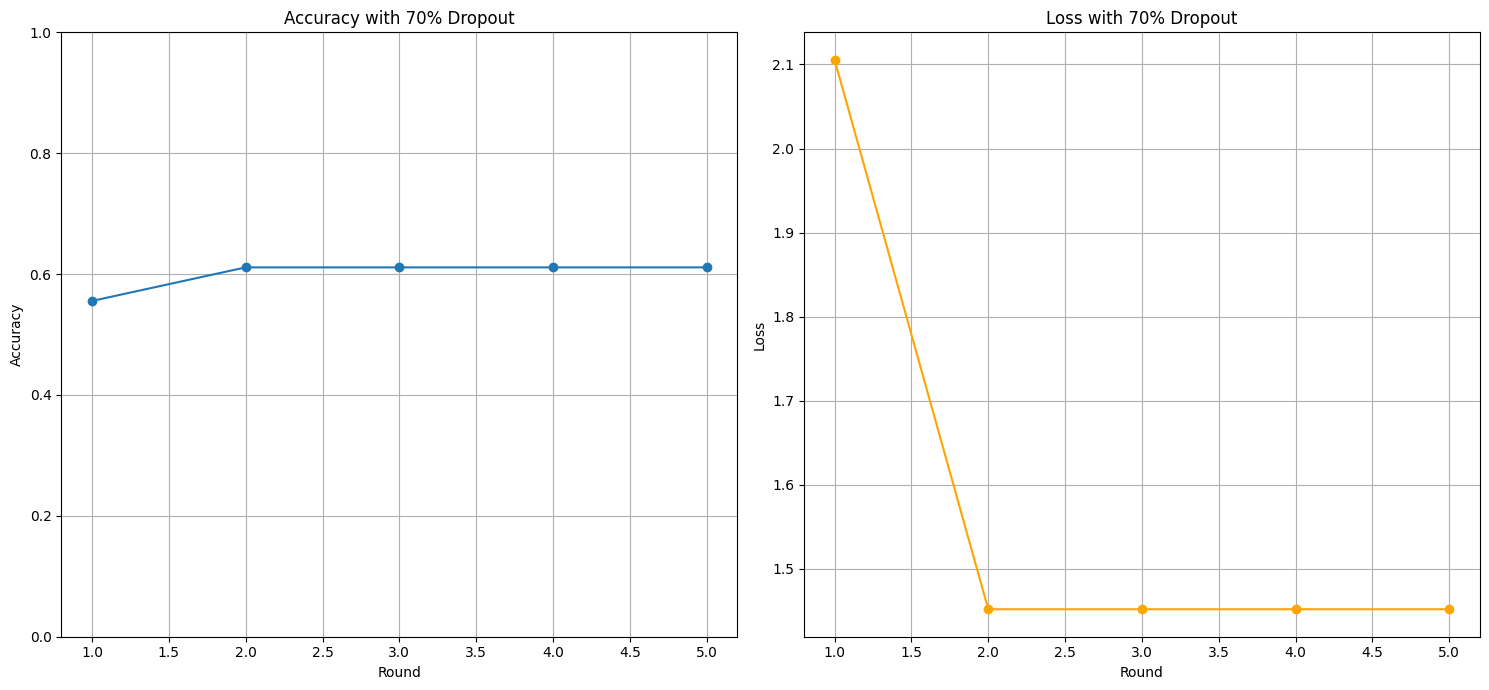

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client



Starting experiment: random_dropout_with_fixed
Dropout rate: 0.5, Pattern: random
Fixed clients: [0]


(pid=78182) 2025-05-01 12:54:02.336377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=78182) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=78182) E0000 00:00:1746104042.379752   78182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=78182) E0000 00:00:1746104042.391302   78182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Round 1: 1 clients dropped out of 3
Dropped client IDs: [13282635017011457999]
(ClientAppActor pid=78182) Epoch 1/5
(ClientAppActor pid=78182) Train - Loss: 5.0856, Accuracy: 0.6786
(ClientAppActor pid=78182) Epoch 2/5
(ClientAppActor pid=78182) Train - Loss: 5.0024, Accuracy: 0.6071
(ClientAppActor pid=78182) Epoch 3/5
(ClientAppActor pid=78180) Epoch 1/5
(ClientAppActor pid=78182) Train - Loss: 5.0943, Accuracy: 0.7500
(ClientAppActor pid=78180) Epoch 3/5 [repeated 4x across cluster]
(ClientAppActor pid=78182) Train - Loss: 2.4766, Accuracy: 0.7857 [repeated 4x across cluster]
(ClientAppActor pid=78180) Epoch 5/5 [repeated 2x across cluster]
(ClientAppActor pid=78180) Train - Loss: 2.1183, Accuracy: 0.8462 [repeated 3x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 1 training metrics: {'loss': 2.3040827783219067, 'accuracy': 0.8148148148148148}
(ClientAppActor pid=78182) Test - Loss: 5.3323, Accuracy: 0.3333


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Round 1 evaluation metrics: {'accuracy': 0.5555555555555556, 'loss': 4.259937056223862}
Round 2: 1 clients dropped out of 3
Dropped client IDs: [13282635017011457999]
(ClientAppActor pid=78180) Epoch 2/5 [repeated 3x across cluster]
(ClientAppActor pid=78180) Train - Loss: 1.1525, Accuracy: 0.8462
(ClientAppActor pid=78182) Train - Loss: 1.8125, Accuracy: 0.8214
(ClientAppActor pid=78182) Test - Loss: 6.1695, Accuracy: 0.5000 [repeated 2x across cluster]
(ClientAppActor pid=78180) Epoch 4/5 [repeated 4x across cluster]
(ClientAppActor pid=78180) Train - Loss: 2.2713, Accuracy: 0.6923 [repeated 3x across cluster]
(ClientAppActor pid=78182) Epoch 5/5 [repeated 3x across cluster]
(ClientAppActor pid=78180) Train - Loss: 0.0634, Accuracy: 0.9615 [repeated 4x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 2 training metrics: {'loss': 0.17288857220742745, 'accuracy': 0.9259259259259259}
(ClientAppActor pid=78182) Test - Loss: 0.1389, Accuracy: 0.8333
(ClientAppActor pid=78182) Train - Loss: 0.2746, Accuracy: 0.8929


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 3)


Round 2 evaluation metrics: {'accuracy': 0.6666666666666666, 'loss': 1.553543810104505}
Round 3: 1 clients dropped out of 3
Dropped client IDs: [13282635017011457999]
(ClientAppActor pid=78182) Epoch 1/5
(ClientAppActor pid=78182) Train - Loss: 0.1777, Accuracy: 0.9286
(ClientAppActor pid=78182) Test - Loss: 3.9291, Accuracy: 0.5000 [repeated 2x across cluster]
(ClientAppActor pid=78182) Epoch 3/5 [repeated 4x across cluster]
(ClientAppActor pid=78182) Train - Loss: 1.0974, Accuracy: 0.8571 [repeated 4x across cluster]
(ClientAppActor pid=78182) Epoch 5/5 [repeated 4x across cluster]
(ClientAppActor pid=78182) Train - Loss: 0.0823, Accuracy: 0.9643 [repeated 4x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 3 training metrics: {'loss': 0.3236185448544607, 'accuracy': 0.9444444444444444}
(ClientAppActor pid=78182) Test - Loss: 0.0000, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=78180) Epoch 5/5
Round 3 evaluation metrics: {'accuracy': 0.8888888888888888, 'loss': 0.8004046685606833}
Round 4: 2 clients dropped out of 3
Dropped client IDs: [1220942046438495152, 13282635017011457999]
(ClientAppActor pid=78180) Epoch 1/5
(ClientAppActor pid=78180) Epoch 2/5
(ClientAppActor pid=78180) Epoch 3/5
(ClientAppActor pid=78180) Train - Loss: 0.4751, Accuracy: 0.8929 [repeated 3x across cluster]
(ClientAppActor pid=78180) Test - Loss: 2.4012, Accuracy: 0.6667 [repeated 2x across cluster]
(ClientAppActor pid=78180) Epoch 4/5
(ClientAppActor pid=78180) Epoch 5/5


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=78180) Train - Loss: 0.0100, Accuracy: 1.0000 [repeated 3x across cluster]
Round 4 training metrics: {'loss': 0.010007818526584547, 'accuracy': 1.0}
(ClientAppActor pid=78182) Test - Loss: 7.7887, Accuracy: 0.5000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 1 clients (out of 3)


Round 4 evaluation metrics: {'accuracy': 0.6111111111111112, 'loss': 5.606996665398279}
Round 5: 2 clients dropped out of 3
Dropped client IDs: [13282635017011457999, 6139750738745500148]
(ClientAppActor pid=78182) Epoch 1/5
(ClientAppActor pid=78182) Epoch 2/5
(ClientAppActor pid=78182) Epoch 3/5
(ClientAppActor pid=78182) Train - Loss: 0.1294, Accuracy: 0.9231 [repeated 2x across cluster]
(ClientAppActor pid=78182) Test - Loss: 7.2996, Accuracy: 0.5000 [repeated 2x across cluster]
(ClientAppActor pid=78182) Epoch 4/5
(ClientAppActor pid=78182) Epoch 5/5
(ClientAppActor pid=78182) Train - Loss: 0.2902, Accuracy: 0.9231 [repeated 3x across cluster]


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Round 5 training metrics: {'loss': 0.2901541628551456, 'accuracy': 0.9230769230769231}
(ClientAppActor pid=78182) Test - Loss: 0.0071, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 106.80s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.259937056223862
INFO :      		round 2: 1.553543810104505
INFO :      		round 3: 0.8004046685606833
INFO :      		round 4: 5.606996665398279
INFO :      		round 5: 2.235511724856527
INFO :      	History (metrics, distributed, fit):
INFO :      	{'accuracy': [(1, 0.8148148148148148),
INFO :      	              (2, 0.9259259259259259),
INFO :      	              (3, 0.9444444444444444),
INFO :      	              (4, 1.0),
INFO :      	              (5, 0.9230769230769231)],
INFO :      	 'loss': [(1, 2.3040827783219067),
INFO :      	          (2, 0.17288857220742745),
INFO :      	          (3, 0.3236185448544607),
INFO :      	          (4, 0.010007818526584547),
INFO :      	          (5, 0.2901541628551456)]}
INFO :      	History (metrics, distributed, evaluate):
INFO :   

Round 5 evaluation metrics: {'accuracy': 0.8888888888888888, 'loss': 2.235511724856527}
(ClientAppActor pid=78182) Test - Loss: 6.6777, Accuracy: 0.6667 [repeated 2x across cluster]


(pid=78180) 2025-05-01 12:54:02.489502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=78180) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=78180) E0000 00:00:1746104042.531699   78180 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=78180) E0000 00:00:1746104042.544673   78180 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


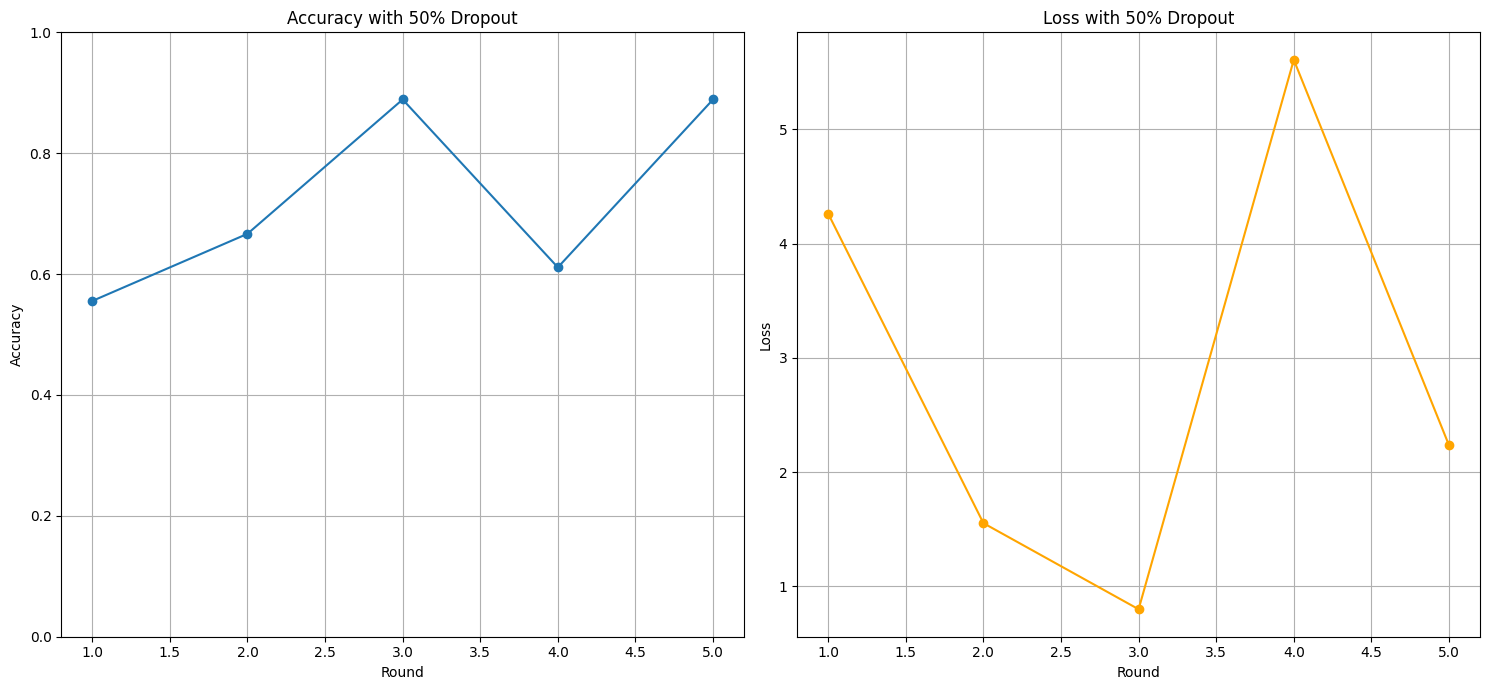

In [43]:
experiment_results = conduct_dropout_experiments(client_func, num_clients=NUM_CLIENTS)